In [6]:
import numpy as np
import matplotlib.pyplot as plt
import generate_data
import economic_analysis
import optimization
import load_ev_schedules as les 
import calculations
import solar_params as solar 
import battery_params as battery
import economic_params as market  
import pandas as pd 
from imp import reload 

# Read data

In [3]:
# Read solar data
annual_capacity_factor = pd.read_csv("solar_profiles/renewables_ninja_profile.csv", skiprows=3)
annual_capacity_factor = annual_capacity_factor['electricity'].values

# Read EV charging schedule data
print("Loading data...")
## Varying levels of EV penetration, without load shedding
annual_25_perc_ev = np.loadtxt(f"processed_ev_schedule_data/annual_25_perc_ev.txt")
annual_50_perc_ev = np.loadtxt(f"processed_ev_schedule_data/annual_50_perc_ev.txt")
annual_75_perc_ev = np.loadtxt(f"processed_ev_schedule_data/annual_75_perc_ev.txt")
annual_100_perc_ev = np.loadtxt(f"processed_ev_schedule_data/annual_100_perc_ev.txt") 



Loading data...


# Arguments

In [4]:
a = {
    # Solar PV Profile 
    'annual_capacity_factor': annual_capacity_factor,
    # EV charging load 
    'load_profile': annual_50_perc_ev,
    # PV costs 
    'pv_cost_per_kw': solar.cost_per_kw,
    'pv_annual_maintenance_cost': solar.annual_maintenance_cost,
    'solar_residual_value_factor': solar.residual_value_factor,
    # PV specifications
    'Rproj': solar.Rproj,
    'solar_annual_degradation': solar.annual_degradation,# 0.6% per year
    # Inverter costs
    'inverter_cost_per_kw': solar.inverter_cost_per_kw, 
    # Battery costs
    'battery_cost_per_kWh': battery.cost_per_kwh,
    'battery_annual_maintenance_cost': battery.annual_maintenance_cost,
    'battery_residual_value_factor': battery.residual_value_factor,
    'depth_of_discharge': battery.depth_of_discharge,
    # Battery specs
    'battery_charging_efficiency': battery.charging_efficiency,
    'battery_discharging_efficiency': battery.discharging_efficiency,
    #'battery_annual_degradation': battery.annual_degradation, # 2% per year
    'battery_duration': battery.duration, 
    'battery_max_cycles': battery.max_cycles,
    'battery_end_of_life_perc': battery.end_of_life_perc,
    'battery_trickle_charging_rate': battery.trickle_charging_rate,
    'battery_lifetime_years': battery.lifetime_years,
    'enable_trickle_charging': False,
    'repurchase_battery': True,
    'limit_battery_repurchases': False,
    # Energy costs and schedule 
    'time_of_use_tariffs_high': market.time_of_use_tariffs_high,
    'time_of_use_tariffs_low': market.time_of_use_tariffs_low,
    'high_period_start': market.high_period_start,
    'high_period_end': market.high_period_end,
    'time_periods': market.time_periods,
    'feed_in_tariff': market.feed_in_tariff,
    # Market inputs 
    'interest rate': market.interest_rate,
    'inflation rate': market.inflation_rate,
    'discount rate': market.discount_rate,
    'cost_diesel': market.cost_diesel,
    # Vehicle specs
    'L_km': market.L_km, 
    'kwh_km': market.kwh_km,
    # Load shedding 
    'load_shedding_bool': True,
    #'load_shedding_schedule': ls_annual_empty,
    # Loan model
  #  'loan_payback_period': market.loan_payback_period,
    # Battery cell specs
    'V_nom': battery.V_nom,
    'V_max':battery.V_max, 
    'R': battery.R, 
    'Q_nom': battery.Q_nom,
    'E_nom': battery.E_nom,
    'a_v': battery.a_v,
    'b_v': battery.b_v
}


# Load, net load, and system output profiles

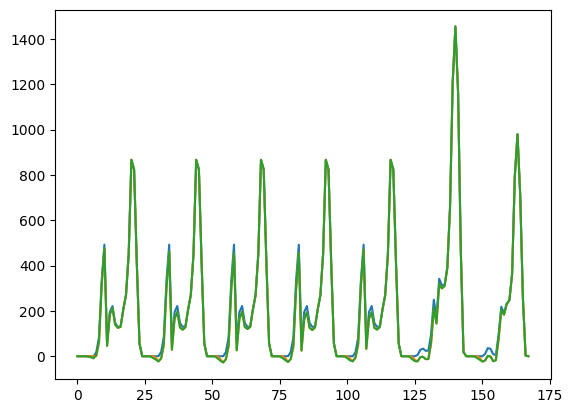

In [7]:
pv_capacity = 50.93
battery_capacity = 19.46 

pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], pv_capacity) 

# # Capital Cost of Investment 
# pv_capital_cost = economic_analysis.calculate_pv_capital_cost(pv_capacity, a)
# battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity

# ## Annual costs
# loan_installment = economic_analysis.calculate_crf(a) * (pv_capital_cost + battery_capital_cost)
# pv_maintenance_cost = a['pv_annual_maintenance_cost'] * pv_capacity
# battery_maintenance_cost = a['battery_annual_maintenance_cost'] * battery_capacity


battery_energy_throughput = 0 # Initialize total quantity of battery energy throughput
repurchase_battery = a['repurchase_battery'] # Initialize battery repurchase bool 
battery_max_energy_throughput = generate_data.get_battery_max_energy_throughput(battery_capacity, a) # Get max battery energy throughput

# net_cash_flows = np.zeros(a['Rproj']) # Initialize array to hold net cash flows 

# battery_exists = True # true until run out of repurchases
    
# Update PV and battery capacity after degradation   
usable_pv_capacity = pv_capacity 
usable_battery_capacity = battery_capacity 
# if battery_exists:
#     usable_battery_capacity = calculations.get_usable_battery_capacity(battery_capacity, battery_energy_throughput, battery_max_energy_throughput, year, a)
    
# Generate PV Output profile 
pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], usable_pv_capacity) 

# # Initialize battery repurchae cost, residual value, and cost of trickle charging (these are all zero at beginning and change throughout)
# battery_repurchase_cost = 0
# battery_residual_value = 0
# cost_of_trickle_charging = 0
    
    ###########################################################################################
    # Battery
    ###########################################################################################  

# Check if the battery is still alive 
# if battery_energy_throughput < battery_max_energy_throughput: 

pv_with_battery_output_profile, battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v4(pv_output_profile, usable_battery_capacity,  battery_energy_throughput, battery_max_energy_throughput, a)

batt_soc, batt_soe = get_battery_energy_profile(pv_output_profile, usable_battery_capacity, a)

# battery_energy_throughput = battery_throughput # update total battery energy throughput 
    
# else:
#     if repurchase_battery: 
#         battery_repurchase_cost = a['battery_cost_per_kWh'] * battery_capacity / (1 + a['discount rate'])**year # rebuy cost (discounted)
#         battery_residual_value = a['battery_residual_value_factor'] * a['battery_cost_per_kWh'] * battery_capacity
        
#         years_left = a['Rproj'] - year
#         crf_repurchase = (a['interest rate'] * (1 + a['interest rate'])**years_left) / ((1 + a['interest rate'])**years_left - 1)
#         loan_installment += crf_repurchase * battery_repurchase_cost

#         usable_battery_capacity = battery_capacity # reset usable battery capacity
#         battery_energy_throughput = 0 # reset battery energy used
#         pv_with_battery_output_profile, battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v4(pv_output_profile, battery_capacity, battery_energy_throughput,battery_max_energy_throughput,a)
#         battery_energy_throughput = battery_throughput
#         if a['limit_battery_repurchases']:
#             repurchase_battery = False
#     else:
#         pv_with_battery_output_profile = pv_output_profile 
#         battery_maintenance_cost = 0
#         battery_exists = False
#         usable_battery_capacity = 0
        
net_load_profile = a['load_profile'] - pv_with_battery_output_profile

load_profile_net_of_only_pv = a['load_profile'] - pv_output_profile
# loadshedding_schedule = a['load_shedding_schedule']
# gross_load_lost_to_loadshedding = np.array([a['load_profile'][i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])

# # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
# saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_lost_to_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]

# # Profile of kWh that would be lost to load shedding WITH solar and battery
# net_load_lost_to_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
# gross_load_minus_loadshedding = a['load_profile'] - gross_load_lost_to_loadshedding
# net_load_minus_loadshedding = net_load_profile - net_load_lost_to_loadshedding 
# value_of_charging_saved_by_pv_from_loadshedding = economic_analysis.get_cost_of_missed_passengers_from_loadshedding_v2(year, saved_free_kWh, a)

# load_profile = gross_load_minus_loadshedding
# net_load_profile = net_load_minus_loadshedding 

            
# energy_savings = economic_analysis.get_energy_savings(cost_of_trickle_charging, load_profile, net_load_profile, year, a) + value_of_charging_saved_by_pv_from_loadshedding.sum()
# maintenance_costs = (pv_maintenance_cost + battery_maintenance_cost) * (1 + a['inflation rate'])**(year - 1)

# net_cash_flows[year] = energy_savings - loan_installment - maintenance_costs - battery_residual_value


# #if in final year
# if year == a['Rproj'] - 1:
#     # add pv residual value to the last cash flow
#     net_cash_flows[-1] += a['solar_residual_value_factor'] * a['pv_cost_per_kw'] * pv_capacity        

plt.plot(a['load_profile'][0:24*7])
plt.plot(net_load_profile[0:24*7])
plt.plot(load_profile_net_of_only_pv[0:24*7])
plt.show()


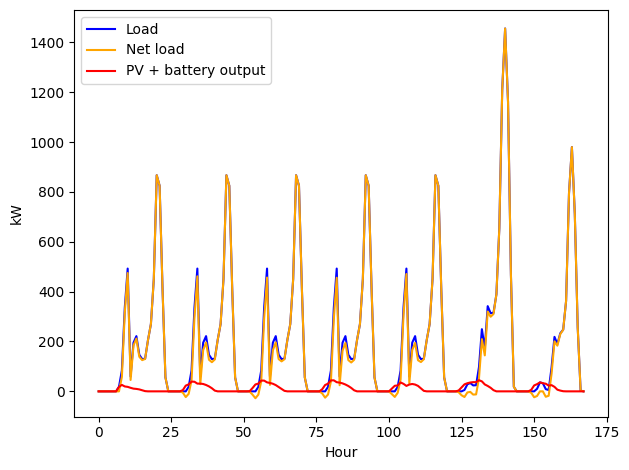

In [8]:
#plt.plot(batt_soc[0:24*7])
fig, ax = plt.subplots()
ax.plot(a['load_profile'][0:24*7], color = 'blue', label = 'Load')
ax.plot(net_load_profile[0:24*7], color = 'orange', label = 'Net load')
#ax2 = ax.twinx()
# ax2.plot(batt_soe[0:24*7], color = 'black', label = 'battery')
# ax2.plot(pv_output_profile[0:24*7], color = 'green', label = 'PV')
ax.plot(pv_with_battery_output_profile[0:24*7], color = 'red', label = 'PV + battery output')
ax.legend(loc='upper left')
ax.set_xlabel("Hour")
ax.set_ylabel("kW")
plt.tight_layout()
plt.savefig('figures/typical_weekly_load')
plt.show()

#ax2.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left', borderaxespad=0.)



In [6]:
def get_battery_energy_profile(pv_output_profile, battery_capacity_total, a):
    
    # Net load profile
    load_profile = np.array(a['load_profile'])
    pv_output_profile = np.array(pv_output_profile)
    net_load_profile = load_profile - pv_output_profile # Calculate the net load profile
        
    # Usable battery capacity
    battery_capacity_usable = a['depth_of_discharge'] * battery_capacity_total # Calculate the amount of battery capacity that can be used
    
    # Max kWh charge or discharge in an hour (c-rating proxy)
    battery_power_rating = battery_capacity_total / a['battery_duration'] 
    
    # Initial energy stored in battery
    battery_current_energy = 0  
    
    # Keep track of total energy moved by the battery 
    battery_energy_draw_from_pv_profile = np.zeros(len(pv_output_profile)) # Energy taken from PV to battery (gross of charging efficiency)
    load_energy_received_from_battery_profile = np.zeros(len(pv_output_profile)) # Energy received by EVs from battery (net of discharging efficiency)
    
    # Keep track of battery state of energy 
    battery_soc = np.zeros(len(pv_output_profile))
    battery_soe = np.zeros(len(pv_output_profile))
    
    
    # Costs
    cost_of_trickle_charging = np.zeros(len(pv_output_profile))
    
    for hour, net_load in enumerate(net_load_profile): 
        
        cost_of_charging = 0
        
        if battery_energy_throughput < battery_max_energy_throughput: # if haven't exceededm maximum energy throughput for the battery
            
            # Update the amount of room (capacity) available in the battery
            battery_room = battery_capacity_usable - battery_current_energy 
            
            # Update state of charge
            state_of_charge = 100 * (battery_current_energy/battery_capacity_total)
            
            
            # Charging efficiency changes at high levels of charge
            if state_of_charge <= 85 :
                curr_charge_efficiency = a['battery_charging_efficiency']
            else:
                curr_charge_efficiency = a['battery_charging_efficiency'] * battery_current_energy
                curr_charge_efficiency = (1 - np.exp((state_of_charge-85)/4)/120) #TODO: Chat with Brendan to get the actual equation
            
            # Taken energy
            energy_stored_in_battery = 0 
            energy_discharged_from_battery = 0
            
            # Useful energy
            energy_drawn_from_pv = 0
            energy_received_by_load = 0
            
            if net_load < 0: # Excess PV production
                
                # Total energy drawn from PV into battery. (limited by room left in the battery, net load available, and battery c-rating,)
                energy_drawn_from_pv = min(battery_room/curr_charge_efficiency, abs(net_load), battery_power_rating)
                
                # Net energy stored in battery
                energy_stored_in_battery = energy_drawn_from_pv * curr_charge_efficiency

                # Update battery state 
                battery_current_energy = battery_current_energy + energy_stored_in_battery
        
            
            elif net_load > 0: # Excess EV Load
                
                # Total energy discharged from battery. (limited by energy available in battery, energy demand, and battery c-rating)
                energy_discharged_from_battery = min(battery_current_energy, net_load/a['battery_discharging_efficiency'], battery_power_rating)  
                
                # Net energy received by EVs
                energy_received_by_load = energy_discharged_from_battery * a['battery_discharging_efficiency']
                
                # Update battery state 
                battery_current_energy = battery_current_energy - energy_discharged_from_battery
                      
            elif net_load == 0: 
                if a['enable_trickle_charging']:
                    if ((hour % 24) < 5) or ((hour % 24) > 20): # Charge from grid only in off-peak times
                        
                        # Total energy drawn from grid (limited by trickle charging rate and room available in battery)
                        energy_drawn_from_grid = min(a['battery_trickle_charging_rate'], battery_room/curr_charge_efficiency)
                        
                        # Net energy stored in battery
                        energy_stored_in_battery = energy_drawn_from_grid * curr_charge_efficiency
                        
                        # Electricity price based on season
                        if (hour > a['high_period_start']) & (hour <= a['high_period_end']): # high period (all peak)
                            elec_price = a['time_of_use_tariffs_high']['off_peak']
                        else:
                            elec_price = a['time_of_use_tariffs_low']['off_peak']
                            
                        # Cost of electricity drawn
                        cost_of_charging = elec_price * energy_drawn_from_grid 
                        
                        # Update battery state 
                        battery_current_energy = battery_current_energy + energy_stored_in_battery  
                        
                
            
            # Useful 
            battery_energy_draw_from_pv_profile[hour] = energy_drawn_from_pv
            load_energy_received_from_battery_profile[hour] = energy_received_by_load
            
            # Cost 
            cost_of_trickle_charging[hour] = max(cost_of_charging, 0)
            
            
            battery_soc[hour] = state_of_charge/100
            battery_soe[hour] = state_of_charge/100 * battery_capacity_total
             
        else: # if there are no cycles left
            break

    
        
    return battery_soc,  battery_soe

# Comparison in lifetime operating costs
Following amry 2023 Fig 9 - 11

In [9]:
def get_cost_of_charging(load_profile, net_load_profile, year, a):

    peak_hours = a['time_periods']['peak_hours']
    standard_hours = a['time_periods']['standard_hours']
    off_peak_hours = a['time_periods']['off_peak_hours']
    
    # Initialize total cost variables
    total_cost_no_pv = np.zeros(len(load_profile))
    total_cost_with_pv = np.zeros(len(net_load_profile))
    
    # Calculate total cost of energy with and without PV
    for i in range(len(total_cost_no_pv)):      
        curr_hour_of_week = i % 168 
        curr_hour_of_day = i % 24
        
        if (i > a['high_period_start']) & (i <= a['high_period_end']): # high period (all peak)
            peak_cost = a['time_of_use_tariffs_high']['peak'] * (1 + a['inflation rate'])**(year - 1)
            standard_cost = a['time_of_use_tariffs_high']['standard'] * (1 + a['inflation rate'])**(year - 1)
            off_peak_cost = a['time_of_use_tariffs_high']['off_peak'] * (1 + a['inflation rate'])**(year - 1) 
        else:
            peak_cost = a['time_of_use_tariffs_low']['peak'] * (1 + a['inflation rate'])**(year - 1)
            standard_cost = a['time_of_use_tariffs_low']['standard'] * (1 + a['inflation rate'])**(year - 1)
            off_peak_cost = a['time_of_use_tariffs_low']['off_peak'] * (1 + a['inflation rate'])**(year - 1)       
             
        if curr_hour_of_week > 120: # weekend is all off-peak
            total_cost_no_pv[i] = load_profile[i] * off_peak_cost 
            if net_load_profile[i] < 0: # If PV output is greater than EV load
                total_cost_with_pv[i] = 0 # No feed-in tariff, so excess supply is curtailed 
            else:
                total_cost_with_pv[i] = net_load_profile[i] * off_peak_cost        
        elif curr_hour_of_day in peak_hours: #peak 
            total_cost_no_pv[i] = load_profile[i] * peak_cost 
            if net_load_profile[i] < 0: 
                total_cost_with_pv[i] = 0 
            else:
                total_cost_with_pv[i] = net_load_profile[i] * peak_cost         
        elif curr_hour_of_day in standard_hours: #standard 
            total_cost_no_pv[i] = load_profile[i] * standard_cost      
            if net_load_profile[i] < 0:
                total_cost_with_pv[i] = 0
            else:
                total_cost_with_pv[i] = net_load_profile[i] * standard_cost     
        else: # off peak       
            total_cost_no_pv[i] = load_profile[i] * off_peak_cost      
            if net_load_profile[i] < 0:
                total_cost_with_pv[i] = 0
            else:
                total_cost_with_pv[i] = net_load_profile[i] * off_peak_cost      
                
                
    return total_cost_no_pv, total_cost_with_pv

In [44]:


# Capital Cost of Investment 
pv_capital_cost = economic_analysis.calculate_pv_capital_cost(pv_capacity, a)
battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity

## Annual costs
loan_installment = economic_analysis.calculate_crf(a) * (pv_capital_cost + battery_capital_cost)
pv_maintenance_cost = a['pv_annual_maintenance_cost'] * pv_capacity
battery_maintenance_cost = a['battery_annual_maintenance_cost'] * battery_capacity


battery_energy_throughput = 0 # Initialize total quantity of battery energy throughput
repurchase_battery = a['repurchase_battery'] # Initialize battery repurchase bool 
battery_max_energy_throughput = generate_data.get_battery_max_energy_throughput(battery_capacity, a) # Get max battery energy throughput

net_cash_flows = np.zeros(a['Rproj']) # Initialize array to hold net cash flows 

battery_exists = True # true until run out of repurchases



maintenance_costs = np.zeros(a['Rproj'])
capital_costs = np.zeros(a['Rproj'])
energy_cost_without_system = np.zeros(a['Rproj'])
energy_cost_with_system = np.zeros(a['Rproj'])
    
for year in range(a['Rproj']):
    
    # Update PV and battery capacity after degradation   
    usable_pv_capacity = calculations.get_usable_pv_capacity(pv_capacity, year, a) 
    
    if battery_exists:
        usable_battery_capacity = calculations.get_usable_battery_capacity(battery_capacity, battery_energy_throughput, battery_max_energy_throughput, year, a)
        
    # Generate PV Output profile 
    pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], usable_pv_capacity) 
    
    # Initialize battery repurchae cost, residual value, and cost of trickle charging (these are all zero at beginning and change throughout)
    battery_repurchase_cost = 0
    battery_residual_value = 0
    cost_of_trickle_charging = 0
        
        ###########################################################################################
        # Battery
        ###########################################################################################  
    
    # Check if the battery is still alive 
    if battery_energy_throughput < battery_max_energy_throughput: 

        pv_with_battery_output_profile, battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v4(pv_output_profile, usable_battery_capacity,  battery_energy_throughput, battery_max_energy_throughput, a)
        
        battery_energy_throughput = battery_throughput # update total battery energy throughput 
        
    else:
        if repurchase_battery: 
            battery_repurchase_cost = a['battery_cost_per_kWh'] * battery_capacity / (1 + a['discount rate'])**year # rebuy cost (discounted)
            battery_residual_value = a['battery_residual_value_factor'] * a['battery_cost_per_kWh'] * battery_capacity
            
            years_left = a['Rproj'] - year
            crf_repurchase = (a['interest rate'] * (1 + a['interest rate'])**years_left) / ((1 + a['interest rate'])**years_left - 1)
            loan_installment += crf_repurchase * battery_repurchase_cost

            usable_battery_capacity = battery_capacity # reset usable battery capacity
            battery_energy_throughput = 0 # reset battery energy used
            pv_with_battery_output_profile, battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v4(pv_output_profile, battery_capacity, battery_energy_throughput,battery_max_energy_throughput,a)
            battery_energy_throughput = battery_throughput
            if a['limit_battery_repurchases']:
                repurchase_battery = False
        else:
            pv_with_battery_output_profile = pv_output_profile 
            battery_maintenance_cost = 0
            battery_exists = False
            usable_battery_capacity = 0
            
            

    net_load_profile = a['load_profile'] - pv_with_battery_output_profile

    total_cost_no_pv_batt_system, total_cost_with_pv_batt_system = get_cost_of_charging(a['load_profile'], net_load_profile, year, a)
    
    maintenance_costs_total = (pv_maintenance_cost + battery_maintenance_cost) * (1 + a['inflation rate'])**(year - 1)
    
   # net_cash_flows[year] = energy_savings - loan_installment - maintenance_costs - battery_residual_value
    
    
    # #if in final year
    # if year == a['Rproj'] - 1:
    #     # add pv residual value to the last cash flow
    #     net_cash_flows[-1] += a['solar_residual_value_factor'] * a['pv_cost_per_kw'] * pv_capacity        
        
    
    maintenance_costs[year] = maintenance_costs_total
    capital_costs[year] = loan_installment
    energy_cost_without_system[year] = total_cost_no_pv_batt_system.sum()
    energy_cost_with_system[year] = total_cost_with_pv_batt_system.sum()
    




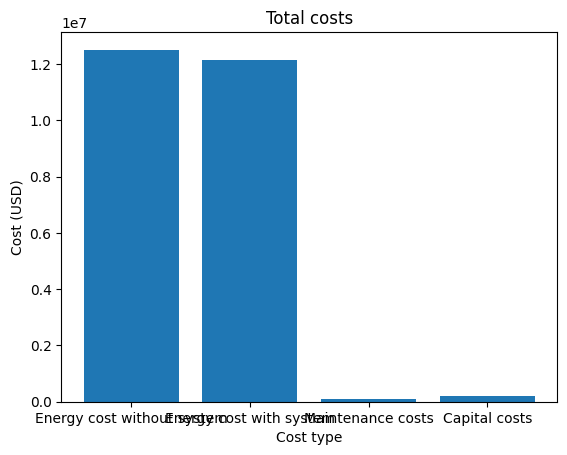

In [45]:
energy_cost_without_system.sum()
energy_cost_with_system.sum()
maintenance_costs.sum()
capital_costs.sum()
# make bar plot of these items
import matplotlib.pyplot as plt

# Define the data
energy_cost_without_system_sum = energy_cost_without_system.sum()
energy_cost_with_system_sum = energy_cost_with_system.sum()
maintenance_costs_sum = maintenance_costs.sum()
capital_costs_sum = capital_costs.sum()

# Create the bar plot
plt.bar(['Energy cost without system', 'Energy cost with system', 'Maintenance costs', 'Capital costs'], 
        [energy_cost_without_system_sum, energy_cost_with_system_sum, maintenance_costs_sum, capital_costs_sum])

# Add labels and title
plt.xlabel('Cost type')
plt.ylabel('Cost (USD)')
plt.title('Total costs')

# Show the plot
plt.show()

# Summary stats for the charging load profiles

In [34]:
weekly_25_perc_ev = les.weekly_25_perc_ev
weekly_50_perc_ev = les.weekly_50_perc_ev
weekly_75_perc_ev = les.weekly_75_perc_ev
weekly_100_perc_ev = les.weekly_100_perc_ev

weekly_ls_1_25_perc_pen = les.weekly_ls_1_25_perc_pen
weekly_ls_2_25_perc_pen = les.weekly_ls_2_25_perc_pen
weekly_ls_3_25_perc_pen = les.weekly_ls_3_25_perc_pen

weekly_ls_1_50_perc_pen = les.weekly_ls_1_50_perc_pen
weekly_ls_2_50_perc_pen = les.weekly_ls_2_50_perc_pen
weekly_ls_3_50_perc_pen = les.weekly_ls_3_50_perc_pen

weekly_ls_1_75_perc_pen = les.weekly_ls_1_75_perc_pen
weekly_ls_2_75_perc_pen = les.weekly_ls_2_75_perc_pen
weekly_ls_3_75_perc_pen = les.weekly_ls_3_75_perc_pen

weekly_ls_1_100_perc_pen = les.weekly_ls_1_100_perc_pen
weekly_ls_2_100_perc_pen = les.weekly_ls_2_100_perc_pen
weekly_ls_3_100_perc_pen = les.weekly_ls_3_100_perc_pen

In [43]:
print(weekly_ls_3_25_perc_pen.sum() , weekly_ls_3_25_perc_pen.max(),  '\n')
print(weekly_ls_3_50_perc_pen.sum() , weekly_ls_3_50_perc_pen.max(),  '\n')
print(weekly_ls_3_75_perc_pen.sum() , weekly_ls_3_75_perc_pen.max(),  '\n')
print(weekly_ls_3_100_perc_pen.sum() , weekly_ls_3_100_perc_pen.max(), '\n')

kWh_charged    6272.566667
dtype: float64 kWh_charged    6.6
dtype: float64 

kWh_charged    20322.5
dtype: float64 kWh_charged    12.466667
dtype: float64 

kWh_charged    30876.266667
dtype: float64 kWh_charged    18.333333
dtype: float64 

kWh_charged    34397.0
dtype: float64 kWh_charged    22.733333
dtype: float64 



# Energy and carbon savings from the system

In [26]:
annual_ls_1_25_perc_pen = les.annual_ls_1_25_perc_pen
annual_ls_2_25_perc_pen = les.annual_ls_2_25_perc_pen
annual_ls_3_25_perc_pen = les.annual_ls_3_25_perc_pen

annual_ls_1_50_perc_pen = les.annual_ls_1_50_perc_pen
annual_ls_2_50_perc_pen = les.annual_ls_2_50_perc_pen
annual_ls_3_50_perc_pen = les.annual_ls_3_50_perc_pen

annual_ls_1_75_perc_pen = les.annual_ls_1_75_perc_pen
annual_ls_2_75_perc_pen = les.annual_ls_2_75_perc_pen
annual_ls_3_75_perc_pen = les.annual_ls_3_75_perc_pen

annual_ls_1_100_perc_pen = les.annual_ls_1_100_perc_pen
annual_ls_2_100_perc_pen = les.annual_ls_2_100_perc_pen
annual_ls_3_100_perc_pen = les.annual_ls_3_100_perc_pen

In [86]:
reload(economic_analysis)
pv_cap = 202.24
batt_cap = 83.35
kwh_ls = 1200773 # kWh
a['load_profile'] = annual_ls_3_100_perc_pen

energy = economic_analysis.get_demand_served_by_system(pv_cap, batt_cap , a)
print("energy:", round(energy/1e6,2), 'GWh')
carbon = energy/1e6 * 0.95 
#print("carbon:", round(carbon,2))


km_kwh = 1 / 0.55 # km/kWh
l_km = 0.15 # l/km
kgco2_l = 2.60 # kgCO2/l
ice_fuel_usage = kwh_ls * km_kwh * l_km # l
ice_fuel_co2_offsets= ice_fuel_usage * kgco2_l #kg CO2
#print("ICE fuel CO2 savings:", ice_fuel_co2_offsets)

grid_energy_offset = energy - kwh_ls
grid_co2_offsets = grid_energy_offset * 0.95 #kg Co2

co2_offsets_MT = (grid_co2_offsets + ice_fuel_co2_offsets)/1e6

print('carbon offsets:', co2_offsets_MT)

energy: 3.62 GWh
carbon offsets: 3.1509770045686616


In [66]:
(energy - kwh_ls)

752500.4398236745

# Summary stats for kWH_LS

In [48]:
annual_ls_1_25_perc_pen = les.annual_ls_1_25_perc_pen
annual_ls_2_25_perc_pen = les.annual_ls_2_25_perc_pen
annual_ls_3_25_perc_pen = les.annual_ls_3_25_perc_pen

annual_ls_1_50_perc_pen = les.annual_ls_1_50_perc_pen
annual_ls_2_50_perc_pen = les.annual_ls_2_50_perc_pen
annual_ls_3_50_perc_pen = les.annual_ls_3_50_perc_pen

annual_ls_1_75_perc_pen = les.annual_ls_1_75_perc_pen
annual_ls_2_75_perc_pen = les.annual_ls_2_75_perc_pen
annual_ls_3_75_perc_pen = les.annual_ls_3_75_perc_pen

annual_ls_1_100_perc_pen = les.annual_ls_1_100_perc_pen
annual_ls_2_100_perc_pen = les.annual_ls_2_100_perc_pen
annual_ls_3_100_perc_pen = les.annual_ls_3_100_perc_pen

In [52]:
from generate_data import generate_loadshedding_profile
import load_shedding_schedules 
## Load shedding schedule 
ls_1 = generate_loadshedding_profile(load_shedding_schedules.ls_1)
ls_2 = generate_loadshedding_profile(load_shedding_schedules.ls_2)
ls_3 = generate_loadshedding_profile(load_shedding_schedules.ls_3)
ls_4 = generate_loadshedding_profile(load_shedding_schedules.ls_4)

## Append them together to make weekly thingy
ls_order_1 = np.concatenate((ls_1, ls_2, ls_3, ls_4, ls_1, ls_2, ls_3), axis = 0)
ls_order_2 = np.concatenate((ls_3, ls_3, ls_2, ls_2, ls_2, ls_2, ls_1), axis = 0)
ls_order_3 = np.concatenate((ls_2, ls_1, ls_1, ls_1, ls_1, ls_4, ls_4), axis = 0)
# Make annual by repeating it 52 times and adding one to the end (MAKE SURE SAME AS IN LOAD_EV_SCHEDULES)
ls_annual_1 = np.concatenate([np.tile(ls_order_1, 52), ls_1], axis = 0)
ls_annual_2 = np.concatenate([np.tile(ls_order_2, 52), ls_2], axis = 0)
ls_annual_3 = np.concatenate([np.tile(ls_order_2, 52), ls_4], axis = 0)
# Empty ls_annual schedule
ls_annual_empty = np.zeros(8760)

In [99]:
a = {
    # Solar PV Profile 
    'annual_capacity_factor': annual_capacity_factor,
    # EV charging load 
    'load_profile': annual_50_perc_ev,
    # PV costs 
    'pv_cost_per_kw': solar.cost_per_kw,
    'pv_annual_maintenance_cost': solar.annual_maintenance_cost,
    'solar_residual_value_factor': solar.residual_value_factor,
    # PV specifications
    'Rproj': solar.Rproj,
    'solar_annual_degradation': solar.annual_degradation,# 0.6% per year
    # Inverter costs
    'inverter_cost_per_kw': solar.inverter_cost_per_kw, 
    # Battery costs
    'battery_cost_per_kWh': battery.cost_per_kwh,
    'battery_annual_maintenance_cost': battery.annual_maintenance_cost,
    'battery_residual_value_factor': battery.residual_value_factor,
    'depth_of_discharge': battery.depth_of_discharge,
    # Battery specs
    'battery_charging_efficiency': battery.charging_efficiency,
    'battery_discharging_efficiency': battery.discharging_efficiency,
    #'battery_annual_degradation': battery.annual_degradation, # 2% per year
    'battery_duration': battery.duration, 
    'battery_max_cycles': battery.max_cycles,
    'battery_end_of_life_perc': battery.end_of_life_perc,
    'battery_trickle_charging_rate': battery.trickle_charging_rate,
    'battery_lifetime_years': battery.lifetime_years,
    'enable_trickle_charging': False,
    'repurchase_battery': True,
    'limit_battery_repurchases': False,
    # Energy costs and schedule 
    'time_of_use_tariffs_high': market.time_of_use_tariffs_high,
    'time_of_use_tariffs_low': market.time_of_use_tariffs_low,
    'high_period_start': market.high_period_start,
    'high_period_end': market.high_period_end,
    'time_periods': market.time_periods,
    'feed_in_tariff': market.feed_in_tariff,
    # Market inputs 
    'interest rate': market.interest_rate,
    'inflation rate': market.inflation_rate,
    'discount rate': market.discount_rate,
    'cost_diesel': market.cost_diesel,
    # Vehicle specs
    'L_km': market.L_km, 
    'kwh_km': market.kwh_km,
    # Load shedding s
    'load_shedding_bool': True,
    'load_shedding_schedule': ls_annual_3,
    # Loan model
  #  'loan_payback_period': market.loan_payback_period,
    # Battery cell specs
    'V_nom': battery.V_nom,
    'V_max':battery.V_max, 
    'R': battery.R, 
    'Q_nom': battery.Q_nom,
    'E_nom': battery.E_nom,
    'a_v': battery.a_v,
    'b_v': battery.b_v
}


In [104]:
kwh_ls = 0
operational_savings = 0


a['load_profile'] = annual_100_perc_ev

pv_capacity = 202.24
battery_capacity = 83.35

# Capital Cost of Investment 
pv_capital_cost = economic_analysis.calculate_pv_capital_cost(pv_capacity, a)
battery_capital_cost = a['battery_cost_per_kWh'] * battery_capacity

## Annual costs
loan_installment = economic_analysis.calculate_crf(a) * (pv_capital_cost + battery_capital_cost)
pv_maintenance_cost = a['pv_annual_maintenance_cost'] * pv_capacity
battery_maintenance_cost = a['battery_annual_maintenance_cost'] * battery_capacity


battery_energy_throughput = 0 # Initialize total quantity of battery energy throughput
repurchase_battery = a['repurchase_battery'] # Initialize battery repurchase bool 
battery_max_energy_throughput = generate_data.get_battery_max_energy_throughput(battery_capacity, a) # Get max battery energy throughput

net_cash_flows = np.zeros(a['Rproj']) # Initialize array to hold net cash flows 

battery_exists = True # true until run out of repurchases
    
for year in range(a['Rproj']):
    
    # Update PV and battery capacity after degradation   
    usable_pv_capacity = calculations.get_usable_pv_capacity(pv_capacity, year, a) 
    
    if battery_exists:
        usable_battery_capacity = calculations.get_usable_battery_capacity(battery_capacity, battery_energy_throughput, battery_max_energy_throughput, year, a)
        
    # Generate PV Output profile 
    pv_output_profile = generate_data.get_pv_output(a['annual_capacity_factor'], usable_pv_capacity) 
    
    # Initialize battery repurchae cost, residual value, and cost of trickle charging (these are all zero at beginning and change throughout)
    battery_repurchase_cost = 0
    battery_residual_value = 0
    cost_of_trickle_charging = 0
        
        ###########################################################################################
        # Battery
        ###########################################################################################  
    
    # Check if the battery is still alive 
    if battery_energy_throughput < battery_max_energy_throughput: 

        pv_with_battery_output_profile, battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v4(pv_output_profile, usable_battery_capacity,  battery_energy_throughput, battery_max_energy_throughput, a)
        
        battery_energy_throughput = battery_throughput # update total battery energy throughput 
        
    else:
        if repurchase_battery: 
            battery_repurchase_cost = a['battery_cost_per_kWh'] * battery_capacity / (1 + a['discount rate'])**year # rebuy cost (discounted)
            battery_residual_value = a['battery_residual_value_factor'] * a['battery_cost_per_kWh'] * battery_capacity
            
            years_left = a['Rproj'] - year
            crf_repurchase = (a['interest rate'] * (1 + a['interest rate'])**years_left) / ((1 + a['interest rate'])**years_left - 1)
            loan_installment += crf_repurchase * battery_repurchase_cost

            usable_battery_capacity = battery_capacity # reset usable battery capacity
            battery_energy_throughput = 0 # reset battery energy used
            pv_with_battery_output_profile, battery_throughput, cost_of_trickle_charging = generate_data.simulate_battery_storage_v4(pv_output_profile, battery_capacity, battery_energy_throughput,battery_max_energy_throughput,a)
            battery_energy_throughput = battery_throughput
            if a['limit_battery_repurchases']:
                repurchase_battery = False
        else:
            pv_with_battery_output_profile = pv_output_profile 
            battery_maintenance_cost = 0
            battery_exists = False
            usable_battery_capacity = 0
            
            

    loadshedding_schedule = a['load_shedding_schedule']
    net_load_profile = a['load_profile'] - pv_with_battery_output_profile
    gross_load_lost_to_loadshedding = np.array([a['load_profile'][i] if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    
    # Profile of kWh that would have been lost to loadshedding but are saved by the solar + battery generation [these are beneficial, and not to be charged $$ for]
    saved_free_kWh = [min(pv_with_battery_output_profile[i], gross_load_lost_to_loadshedding[i]) if is_shedding else 0 for i, is_shedding in enumerate(loadshedding_schedule)]
    
    kwh_ls += sum(saved_free_kWh)
    
    
    # Profile of kWh that would be lost to load shedding WITH solar and battery
    net_load_lost_to_loadshedding = np.array([net_load_profile[i] if is_shedding and net_load_profile[i] > 0 else 0 for i, is_shedding in enumerate(loadshedding_schedule)])
    gross_load_minus_loadshedding = a['load_profile'] - gross_load_lost_to_loadshedding
    net_load_minus_loadshedding = net_load_profile - net_load_lost_to_loadshedding 
    value_of_charging_saved_by_pv_from_loadshedding = economic_analysis.get_cost_of_missed_passengers_from_loadshedding_v2(year, saved_free_kWh, a)
    
    load_profile = gross_load_minus_loadshedding
    net_load_profile = net_load_minus_loadshedding 

                
    energy_savings = economic_analysis.get_energy_savings(cost_of_trickle_charging, load_profile, net_load_profile, year, a) + value_of_charging_saved_by_pv_from_loadshedding.sum()
    maintenance_costs = (pv_maintenance_cost + battery_maintenance_cost) * (1 + a['inflation rate'])**(year - 1)
    
    net_cash_flows[year] = energy_savings - loan_installment - maintenance_costs - battery_residual_value
    
    
    operational_savings += value_of_charging_saved_by_pv_from_loadshedding.sum()
    
    
    #if in final year
    if year == a['Rproj'] - 1:
        # add pv residual value to the last cash flow
        net_cash_flows[-1] += a['solar_residual_value_factor'] * a['pv_cost_per_kw'] * pv_capacity        

npv = economic_analysis.calculate_npv(initial_investment = 0, cash_flows = net_cash_flows, discount_rate = a['discount rate'])
# breakpoint()

print("NPV: $", round(npv))
print("kWh saved from load shedding: ", round(kwh_ls))
print("Operational savings: $", round(operational_savings))

NPV: $ 129266
kWh saved from load shedding:  1200773
Operational savings: $ 518261


In [109]:
reload(economic_analysis)
economic_analysis.get_kwh_ls_and_op_savings(100, 100, a)

29430.485132041606 5141.042732807033
58678.20102953349 10610.675542024712
87744.93922812765 16430.03389287903
116632.92812623162 22621.716147868727
145343.11680912564 29209.499309753337
173876.84052430617 36218.76230033674
202234.5911624162 43676.28642809987
230416.53675049127 51610.483259114684
258424.54497095823 60052.059353344004
286259.4817210651 69033.3890585627
313921.80120026023 78588.73853607691
341412.47073988576 88754.74311020455
368733.14472841093 99570.62573534151
395886.04210183315 111078.36244004735
422871.4076707768 123321.7963124087
449689.4677494733 136347.52309263943
476341.45743603265 150205.627357207
502828.2275487862 164949.16084790332
529150.8117199307 180634.69823809704
555310.6238487569 197322.68169230496
581308.724093611 215077.04170256894
607147.3293699777 233966.77740574515
632828.8920041642 254065.62906015664
658355.938337131 275452.28907056554
683729.0596854067 298208.86526633624


(683729.0596854067, 298208.86526633624)

# Making bar charts of main results

                 Parameter            & Low      & Med       & High       & Full        \\ 
                        \hline
                        PV rating (kW)        & 0        & 50.94     &  122.66    & 128.41      \\
                        Battery rating (kWh)  & 0        & 19.46     &  22.12     & 26.21       \\
                        NPV (\$)              & 0        & 12,015    &  49,002    & 51,457      \\
                        Capital cost (\$)  & 0           & 61,439    &  138,050   & 145,752     \\
                        ROI (\%)              & -        & 19.6      &  35.5      & 35.3        \\
                        $LCOE_{PV}$ (\$/kWh)  & -        & 0.115     &  0.109     & 0.109       \\
                        $LCOE_{Batt}$ (\$/kWh)& -        & 0.158     &  0.133     & 0.129       \\
                        $D_{sys}$ (GWh)       & -        & 1.16      &  2.76      & 2.92        \\ % total load serve by sis.
                        $CO2_{savings}$  (Kt) & -        & 1.10      &  2.62      & 2.77      \\
                        % $F_{sys}$            &          &           &            &       \\ % percent of load served by system
                        % $UR$                 &          &           &            &       \\ % utilization rate 
                        % $Red_{peak}$         &          &           &            &       \\
                    \end{tabular}

PV rating

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36379/364492852.py:41: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36379/364492852.py:45: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


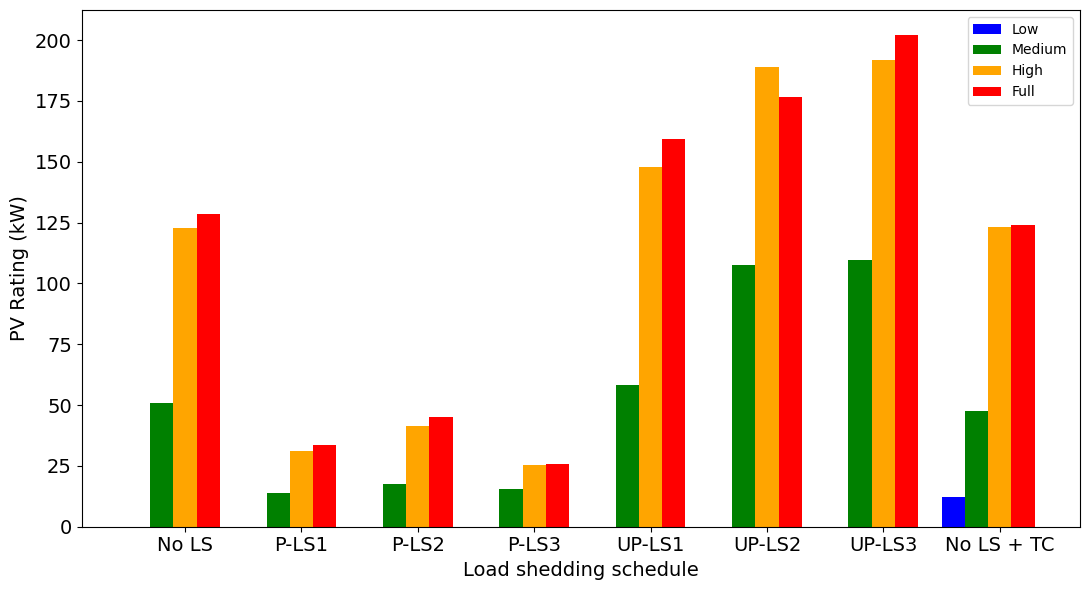

In [37]:

# Define the scenarios and cases
scenarios = ["No LS", "P-LS1", "P-LS2", "P-LS3", "UP-LS1", "UP-LS2", "UP-LS3", "No LS + TC"]
cases = ["Low", "Medium", "High", "Full"]

# Example data (you can replace this with your actual data)
data = {
    "No LS": [0, 50.94, 122.66, 128.41],
    "P-LS1": [0, 13.92, 31.07, 33.45],
    "P-LS2": [0, 17.42, 41.35, 45.25],
    "P-LS3": [0, 15.50, 25.41, 25.93],
    "UP-LS1": [0, 58.14, 147.76, 159.49],
    "UP-LS2": [0, 107.65, 188.73, 176.40],
    "UP-LS3": [0, 109.73, 191.75, 202.24],
    "No LS + TC": [12.27, 47.52, 123.03, 124.07]
}

# Create a figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(11, 6)
# Set the width of the bars
bar_width = 0.2
index = np.arange(len(scenarios))
colors = ['blue', 'green', 'orange', 'red']

# Create bars for each case in each scenario
for i, case in enumerate(cases):
    values = [data[scenario][i] for scenario in scenarios]
    ax.bar(index + i * bar_width, values, bar_width, label=case, color = colors[i])

# Set the x-axis labels and title
ax.set_xlabel("Load shedding schedule",fontsize = 14)
ax.set_ylabel("PV Rating (kW)", fontsize = 14)
#ax.set_title("Bar Chart with Scenarios and Cases")

# Set the x-axis ticks and labels
ax.set_xticks(index + bar_width * len(cases) / 2)
ax.set_xticklabels(scenarios)

#make xticklabels fontsize 14
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
#make yticklabels fontsize 14
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig("figures/pv_rating_results.png")
plt.show()


Battery rating

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36379/3183402045.py:37: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36379/3183402045.py:41: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


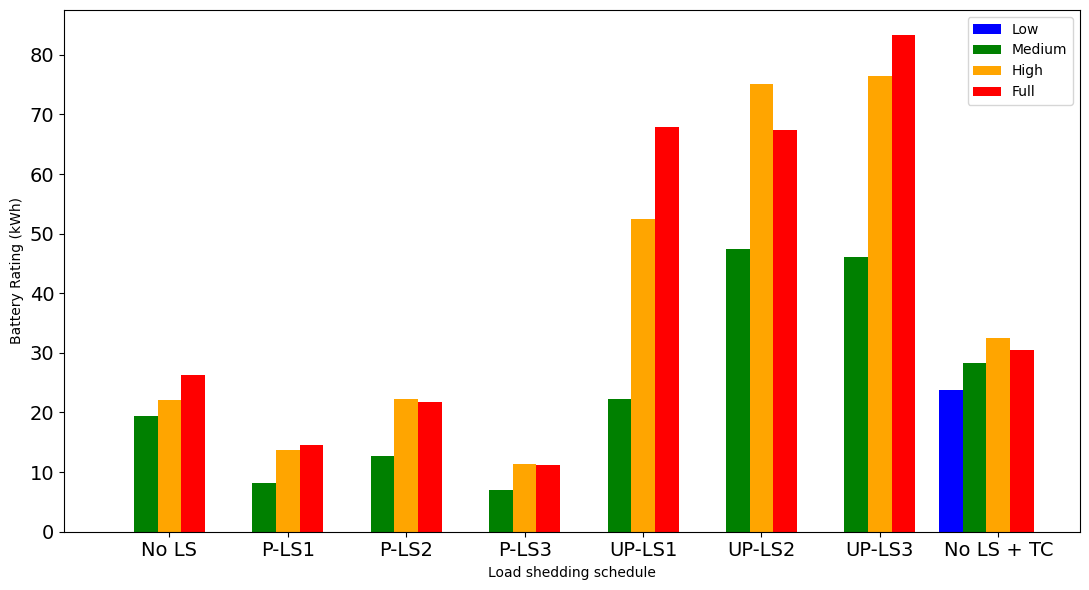

In [38]:

# Example data (you can replace this with your actual data)
data = {
    "No LS": [0, 19.46, 22.12, 26.21],
    "P-LS1": [0, 8.23, 13.64, 14.58],
    "P-LS2": [0, 12.71, 22.22, 21.73],
    "P-LS3": [0, 7.00, 11.29, 11.13],
    "UP-LS1": [0, 22.29, 52.46, 67.95],
    "UP-LS2": [0, 47.37, 75.13, 67.33],
    "UP-LS3": [0, 46.16, 76.40, 83.35],
    "No LS + TC": [23.85, 28.25, 32.47, 30.45]
}

# Create a figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(11, 6)
# Set the width of the bars
bar_width = 0.2
index = np.arange(len(scenarios))
colors = ['blue', 'green', 'orange', 'red']

# Create bars for each case in each scenario
for i, case in enumerate(cases):
    values = [data[scenario][i] for scenario in scenarios]
    ax.bar(index + i * bar_width, values, bar_width, label=case, color = colors[i])

# Set the x-axis labels and title
ax.set_xlabel("Load shedding schedule")
ax.set_ylabel("Battery Rating (kWh)")
#ax.set_title("Bar Chart with Scenarios and Cases")

# Set the x-axis ticks and labels
ax.set_xticks(index + bar_width * len(cases) / 2)
ax.set_xticklabels(scenarios)

#make xticklabels fontsize 14
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
#make yticklabels fontsize 14
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)


# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig("figures/battery_rating_results.png")
plt.show()


Capital cost

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36379/1791675861.py:37: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36379/1791675861.py:41: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


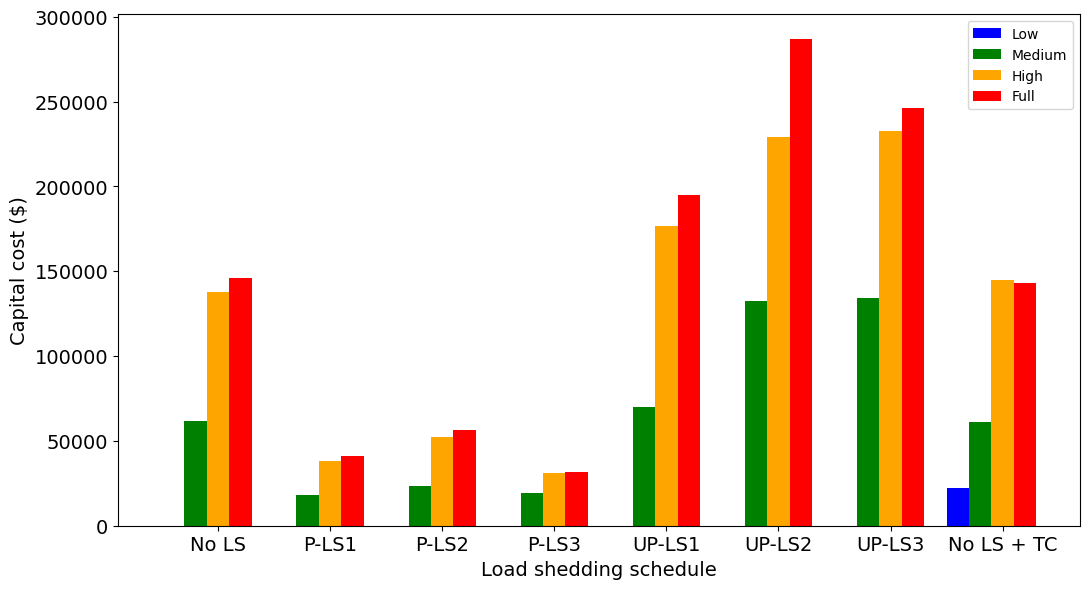

In [39]:

# Example data (you can replace this with your actual data)
data = {
    "No LS": [0, 61439, 138050, 145752],
    "P-LS1": [0, 17952, 38183, 41063],
    "P-LS2": [0, 23432, 52444, 56352],
    "P-LS3": [0, 19124, 31280, 31765],
    "UP-LS1": [0, 70164, 176633, 195179],
    "UP-LS2": [0, 132343, 228852, 287054],
    "UP-LS3": [0, 134052, 232551, 246373],
    "No LS + TC": [22460, 61359, 144579, 142876]
}

# Create a figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(11, 6)
# Set the width of the bars
bar_width = 0.2
index = np.arange(len(scenarios))
colors = ['blue', 'green', 'orange', 'red']

# Create bars for each case in each scenario
for i, case in enumerate(cases):
    values = [data[scenario][i] for scenario in scenarios]
    ax.bar(index + i * bar_width, values, bar_width, label=case, color = colors[i])

# Set the x-axis labels and title
ax.set_xlabel("Load shedding schedule", fontsize =14)
ax.set_ylabel("Capital cost ($)", fontsize =14)
#ax.set_title("Bar Chart with Scenarios and Cases")

# Set the x-axis ticks and labels
ax.set_xticks(index + bar_width * len(cases) / 2)
ax.set_xticklabels(scenarios)

#make xticklabels fontsize 14
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
#make yticklabels fontsize 14
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)


# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig("figures/capital_cost_results.png")
plt.show()


NPV

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36379/432454013.py:43: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)
/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36379/432454013.py:47: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


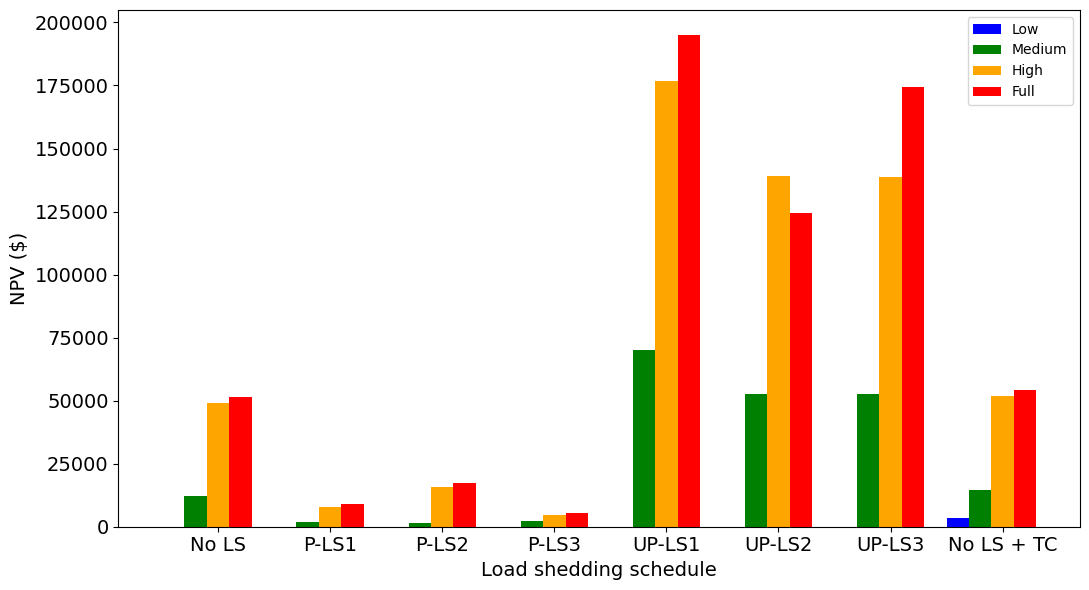

In [40]:

# Define the scenarios and cases
scenarios = ["No LS", "P-LS1", "P-LS2", "P-LS3", "UP-LS1", "UP-LS2", "UP-LS3", "No LS + TC"]
cases = ["Low", "Medium", "High", "Full"]

# Example data (you can replace this with your actual data)
data = {
    "No LS": [0, 12015, 49002, 51457],
    "P-LS1": [0, 1728, 8003, 9064],
    "P-LS2": [0, 1334, 15908, 17203],
    "P-LS3": [0, 2397, 4504, 5526],
    "UP-LS1": [0, 70164, 176633, 195179],
    "UP-LS2": [0, 52494, 139068, 124559],
    "UP-LS3": [0, 52446, 138759, 174235],
    "No LS + TC": [3379, 14628, 51926, 54197]
}

# Create a figure and axis
fig, ax = plt.subplots()
# make plot bigger
fig.set_size_inches(11, 6)

# Set the width of the bars
bar_width = 0.2
index = np.arange(len(scenarios))
colors = ['blue', 'green', 'orange', 'red']

# Create bars for each case in each scenario
for i, case in enumerate(cases):
    values = [data[scenario][i] for scenario in scenarios]
    ax.bar(index + i * bar_width, values, bar_width, label=case, color = colors[i])

# Set the x-axis labels and title
ax.set_xlabel("Load shedding schedule", fontsize =14)
ax.set_ylabel("NPV ($)", fontsize =14)
#ax.set_title("Bar Chart with Scenarios and Cases")

# Set the x-axis ticks and labels
ax.set_xticks(index + bar_width * len(cases) / 2)
ax.set_xticklabels(scenarios)

#make xticklabels fontsize 14
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
#make yticklabels fontsize 14
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig("figures/npv_results.png")
plt.show()


In [50]:
import economic_analysis
import load_ev_schedules as les 
import input_params
a=  input_params.a
from imp import reload 
reload(economic_analysis)
economic_analysis.get_energy_served_by_pv(20, 20, les.annual_50_perc_ev, a)

355108.76018869824

In [ ]:
economic_analysis.get_cost_of_energy()